In [0]:
"""
Bitcoin Price Forecasting with ARIMA  
Spring 2025 - DATA605 Final Project 
Author: Ritik | UMD | Databricks CLI Automation
Last updated: 2025-04-05
"""
# Config
DBFS_DATA_PATH = "dbfs:/bitcoin/bitcoin_price.json"
DBFS_OUTPUT_PATH = "dbfs:/bitcoin/forecast_output.csv"
MODEL_ORDER = (1, 1, 1) 
ARIMA_ORDER_CANDIDATES = [(1, 1, 1), (2, 1, 2), (0, 1, 1)]

from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import logging


logging.basicConfig()
logger = logging.getLogger("bitcoin_forecast")
logger.setLevel(logging.INFO)
logger.info("✅ Libraries loaded and config set")

INFO:bitcoin_forecast:✅ Libraries loaded and config set


In [0]:
def load_data(dbfs_path):
    """Load and validate raw data from DBFS"""
    try:
        raw_df = spark.read.text(dbfs_path)
        if raw_df.isEmpty():
            raise ValueError(f"No data found at {dbfs_path}")
        
        logger.info(f"📊 Loaded {raw_df.count()} rows from DBFS")
        return raw_df
    except Exception as e:
        logger.error(f"🚨 Data loading failed: {str(e)}")
        raise


raw_df = load_data(DBFS_DATA_PATH)
raw_df.show(5, truncate=False)



INFO:bitcoin_forecast:📊 Loaded 563 rows from DBFS


+-----------------------------------------------------------+
|value                                                      |
+-----------------------------------------------------------+
|{"timestamp": "2025-03-30T04:25:56.663227", "price": 83060}|
|{"timestamp": "2025-03-30T05:39:57.371254", "price": 83122}|
|{"timestamp": "2025-03-30T05:40:58.257615", "price": 83112}|
|{"timestamp": "2025-03-30T05:41:46.834078", "price": 83112}|
|{"timestamp": "2025-03-30T05:41:49.688149", "price": 83112}|
+-----------------------------------------------------------+
only showing top 5 rows



In [0]:
def clean_data(raw_df):
    try:
        price_data = raw_df.rdd.map(lambda row: json.loads(row['value'])).collect()
        logger.info(f"Collected {len(price_data)} records from RDD.")
        print(f"DEBUG: Collected {len(price_data)} records from RDD.")

        required_keys = {'timestamp', 'price'}
        if not all(required_keys.issubset(d.keys()) for d in price_data):
            missing_keys_samples = [d for d in price_data[:10] if not required_keys.issubset(d.keys())]
            logger.error(f"JSON missing required keys {required_keys}. Sample missing records: {missing_keys_samples}")
            raise KeyError(f"JSON missing required keys {required_keys}")

        pdf = pd.DataFrame(price_data)
        logger.info(f"Initial DataFrame shape: {pdf.shape}")
        print(f"DEBUG: Initial DataFrame shape: {pdf.shape}")

        # --- Timestamp Conversion ---
        pdf['timestamp_dt'] = pd.to_datetime(
            pdf['timestamp'],
            errors='coerce',
            utc=True
        )
        rows_before_ts_dropna = len(pdf)
        pdf.dropna(subset=['timestamp_dt'], inplace=True)
        logger.info(f"Dropped {rows_before_ts_dropna - len(pdf)} rows due to NaT timestamps. Shape after TS dropna: {pdf.shape}")
        print(f"DEBUG: Dropped {rows_before_ts_dropna - len(pdf)} rows due to NaT timestamps. Shape after TS dropna: {pdf.shape}") # DEBUG

        if pdf.empty or not pd.api.types.is_datetime64_any_dtype(pdf['timestamp_dt']):
            logger.error("Timestamp column failed to convert or resulted in empty DataFrame after NaT drop.")
            raise TypeError("Timestamp column could not be converted or no valid data remained after NaT drop.")

        pdf['timestamp_naive'] = pdf['timestamp_dt'].dt.tz_localize(None)

        # --- Price Conversion ---
        pdf['price'] = pd.to_numeric(pdf['price'], errors='coerce')
        rows_before_price_dropna = len(pdf)
        pdf.dropna(subset=['price'], inplace=True)
        logger.info(f"Dropped {rows_before_price_dropna - len(pdf)} rows due to non-numeric prices. Shape after price dropna: {pdf.shape}")
        print(f"DEBUG: Dropped {rows_before_price_dropna - len(pdf)} rows due to non-numeric prices. Shape after price dropna: {pdf.shape}") # DEBUG

        if pdf.empty:
             logger.error("DataFrame empty after price conversion/dropna.")
             raise ValueError("DataFrame empty after price conversion/dropna.")

        # --- Sorting & Deduplication ---
        pdf = pdf.sort_values('timestamp_naive')
        rows_before_dedup = len(pdf)
        pdf = pdf.drop_duplicates(subset=['timestamp_naive'], keep='last')
        logger.info(f"Dropped {rows_before_dedup - len(pdf)} duplicate timestamp rows. Shape after dedup: {pdf.shape}")
        print(f"DEBUG: Dropped {rows_before_dedup - len(pdf)} duplicate timestamp rows. Shape after dedup: {pdf.shape}") 
        pdf.set_index('timestamp_naive', inplace=True)

        pdf = pdf.drop(columns=['timestamp', 'timestamp_dt'])

        if pdf.empty:
             logger.error("DataFrame empty after sorting/deduplication.")
             raise ValueError("DataFrame empty after sorting/deduplication.")

        # --- Feature Engineering ---
        if len(pdf) < 2:
             logger.warning(f"Insufficient data points ({len(pdf)}) for feature engineering. Skipping.")
             print(f"DEBUG: Insufficient data points ({len(pdf)}) for feature engineering. Skipping.")
             return pdf[['price']]

        pdf['price_change_pct'] = pdf['price'].pct_change()

        if len(pdf) < 5:
             logger.warning(f"Insufficient data points ({len(pdf)}) for rolling mean window 5. Skipping MA.")
             print(f"DEBUG: Insufficient data points ({len(pdf)}) for rolling mean window 5. Skipping MA.") 
             pdf['price_ma_5'] = pd.NA
        else:
             pdf['price_ma_5'] = pdf['price'].rolling(window=5).mean()
        logger.info(f"Shape after feature engineering (before final dropna): {pdf.shape}")
        print(f"DEBUG: Shape after feature engineering (before final dropna): {pdf.shape}") 

        # --- Final Dropna ---
        initial_rows_final = len(pdf)
        pdf.dropna(subset=['price_change_pct'], inplace=True)
        logger.info(f"Dropped {initial_rows_final - len(pdf)} row(s) due to pct_change NaN. Shape after final dropna: {pdf.shape}")
        print(f"DEBUG: Dropped {initial_rows_final - len(pdf)} row(s) due to pct_change NaN. Shape after final dropna: {pdf.shape}")

        if pdf.empty:
             logger.warning("DataFrame became empty after final dropna (likely due to pct_change).")
             raise ValueError("DataFrame became empty after final dropna.")

        logger.info("🧹 Data cleaned successfully")
        cols_to_return = ['price']
        if 'price_change_pct' in pdf.columns and not pdf['price_change_pct'].isna().all():
             cols_to_return.append('price_change_pct')
        if 'price_ma_5' in pdf.columns and not pdf['price_ma_5'].isna().all():
            cols_to_return.append('price_ma_5')
        return pdf[cols_to_return]

    except Exception as e:
        logger.error(f"🧹 Data cleaning failed: {str(e)}")
        logger.error(f"Original error type: {type(e).__name__}")
        raise

# Execute
pdf = clean_data(raw_df)
pdf.tail()



INFO:bitcoin_forecast:🧹 Data cleaned successfully


,price,price_change_pct,price_ma_5
timestamp,,,
2025-04-04 23:06:16.776352,84021,0.000202,84073.0
2025-04-04 23:21:17.653113,83830,-0.002273,84007.4
2025-04-04 23:36:18.529621,83645,-0.002207,83922.2
2025-04-04 23:51:19.373141,83859,0.002558,83871.8
2025-04-05 00:06:20.582858,83808,-0.000608,83832.6


/root/.ipykernel/984/command-7606466433313293-1979290215:16: UserWarning: Glyph 8383 (\N{BITCOIN SIGN}) missing from current font.
  plt.tight_layout()
/databricks/python/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8383 (\N{BITCOIN SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


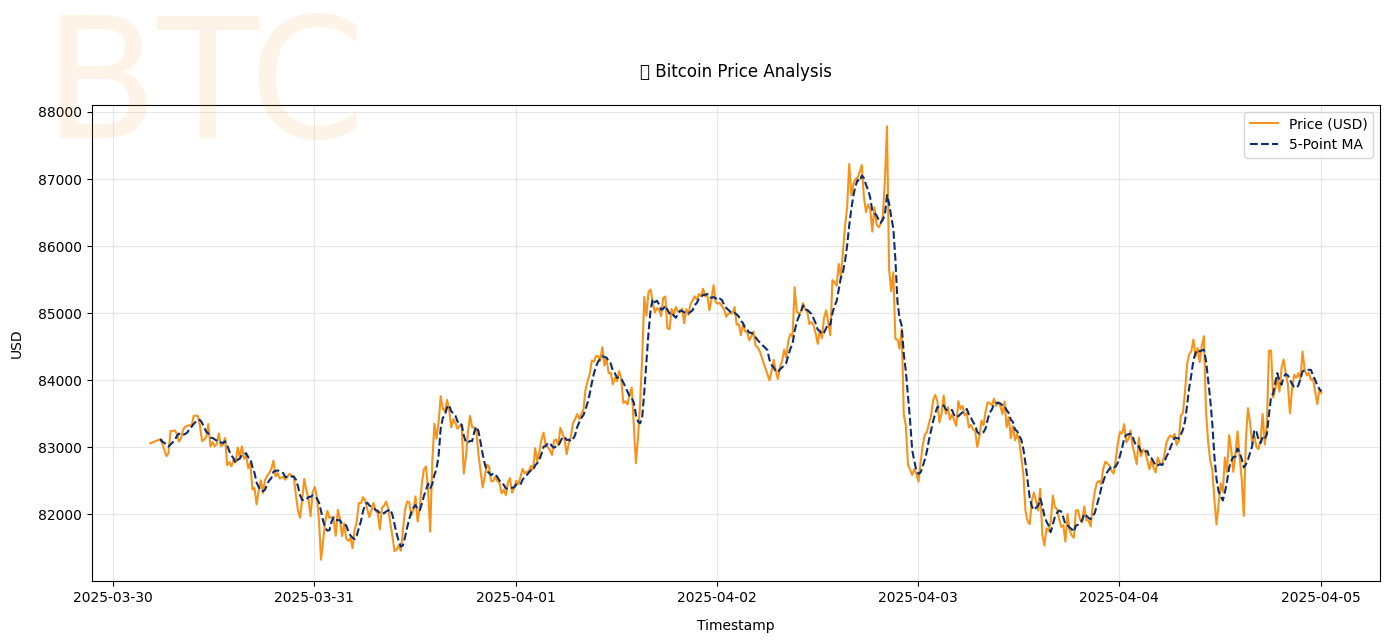

In [0]:
def plot_historical(data: pd.DataFrame):
    """Plot price history with moving average"""
    plt.figure(figsize=(14, 6))
    plt.plot(data.index, data['price'], label="Price (USD)", color="#F7931A")  # BTC orange
    plt.plot(data.index, data['price_ma_5'], label="5-Point MA", linestyle="--", color="#0D2D6C")
    
    plt.title("₿ Bitcoin Price Analysis", pad=20)
    plt.xlabel("Timestamp", labelpad=10)
    plt.ylabel("USD", labelpad=10)
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.figtext(0.15, 0.85, "BTC", fontsize=120, alpha=0.1, color="#F7931A", ha='center')
    plt.tight_layout()
    plt.show()

# Execute
plot_historical(pdf)



/databricks/python/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


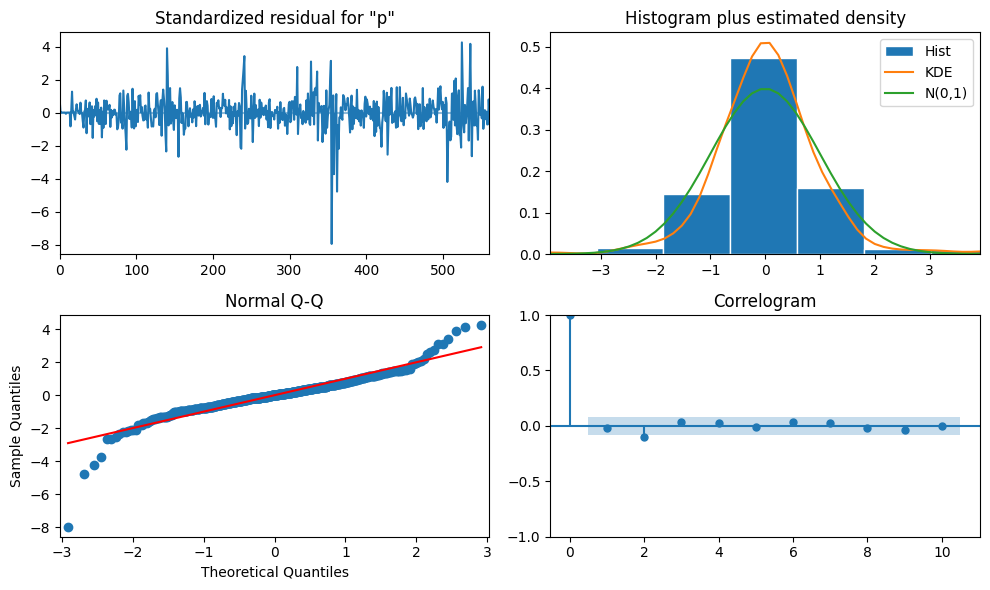

/databricks/python/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/databricks/python/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [0]:

def train_arima(data: pd.Series):
    """ARIMA training with manual order selection"""
    try:
        model = ARIMA(data, order=MODEL_ORDER).fit()
    
        orders = ARIMA_ORDER_CANDIDATES
        best_model = None
        best_order = None
        best_aic = np.inf

        for order in orders:
            try:
                trial_model = ARIMA(data, order=order).fit()
                trial_aic = trial_model.aic
                logger.info(f" Order {order} AIC: {trial_aic:.1f}")
                if trial_aic < best_aic:
                    best_model = trial_model
                    best_order = order
                    best_aic = trial_aic
            except Exception as e:
                logger.warning(f" ARIMA{order} failed: {e}")

        if best_model is None:
            raise RuntimeError("No valid ARIMA model could be fit.")

        logger.info(f" Selected ARIMA{best_order} | AIC: {best_aic:.1f}")
        return best_model, best_order
    except Exception as e:
        logger.error(f"ARIMA failed: {e}")
        raise RuntimeError("ARIMA model training failed. Check input data.")

model_fit, best_order = train_arima(pdf['price'])
model_fit.plot_diagnostics(figsize=(10, 6))
plt.tight_layout()
plt.show()
forecast_results = model_fit.get_forecast(steps=10)
forecast = forecast_results.predicted_mean
conf_int = forecast_results.conf_int()



/root/.ipykernel/984/command-7606466433313295-1583194347:28: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from current font.
  plt.tight_layout()
/databricks/python/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


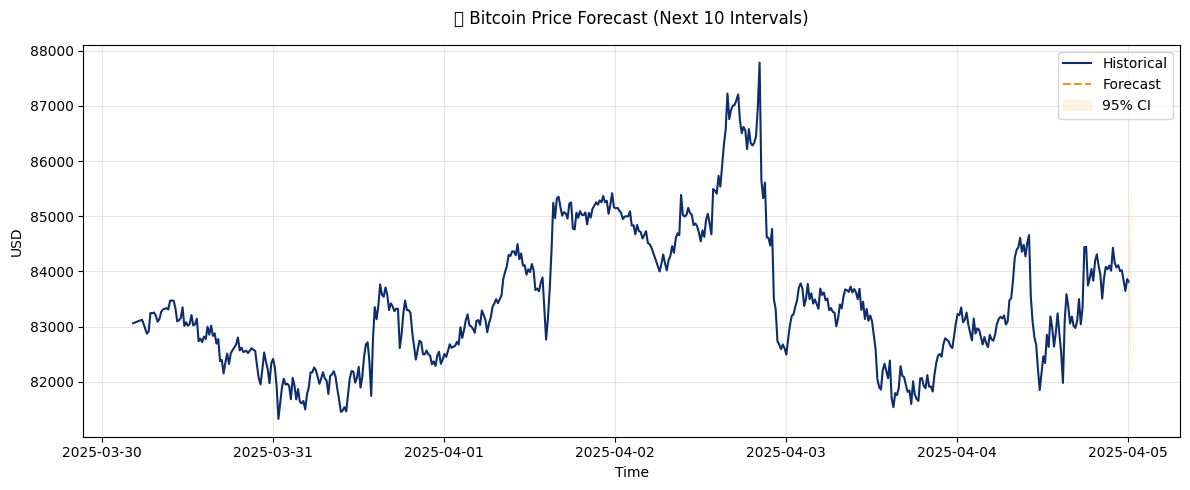

In [0]:
def plot_forecast(history: pd.DataFrame, forecast: pd.Series, conf_int=None):
    """Plot historical data + forecast"""
    future_index = pd.date_range(
        start=history.index[-1] + pd.Timedelta(minutes=1),
        periods=len(forecast),
        freq='T'
    )
    
    plt.figure(figsize=(12, 5))
    plt.plot(history.index, history['price'], label='Historical', color="#0D2D6C")
    plt.plot(future_index, forecast, label='Forecast', linestyle="--", color="#F7931A")
    
    if conf_int is not None:
        plt.fill_between(
            future_index,
            conf_int.iloc[:, 0],
            conf_int.iloc[:, 1],
            color='orange',
            alpha=0.1,
            label='95% CI'
        )
    
    plt.title('🔮 Bitcoin Price Forecast (Next 10 Intervals)', pad=15)
    plt.xlabel('Time')
    plt.ylabel('USD')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Execute
plot_forecast(pdf, forecast, forecast_results.conf_int())



In [0]:
def save_results(forecast: pd.Series, history: pd.DataFrame, model_order):
    """Save forecast to DBFS with metadata"""
    try:
        future_index = pd.date_range(
            start=history.index[-1] + pd.Timedelta(minutes=15),
            periods=len(forecast),
            freq='15T'
        )
        forecast_df = pd.DataFrame({
            'timestamp': future_index,
            'forecast_price': forecast,
            'model': str(model_order),
            'last_trained': pd.Timestamp.now().isoformat() 
        })
        
        output_path = DBFS_OUTPUT_PATH.replace("dbfs:/", "/dbfs/")
        forecast_df.to_csv(output_path, index=False)
        logger.info(f" Saved forecast to {output_path}")
        
        # Verification
        assert len(dbutils.fs.ls("dbfs:/bitcoin/")) > 0, "DBFS write failed"
        logger.info(" DBFS write verified")
    except Exception as e:
        logger.error(f" Failed to save results: {str(e)}")
        raise

# Execute
save_results(forecast, pdf, best_order)



INFO:bitcoin_forecast:💾 Saved forecast to /dbfs/bitcoin/forecast_output.csv
INFO:bitcoin_forecast:✅ DBFS write verified


In [0]:
# Validation
assert not pdf.empty, "DataFrame should not be empty"
assert pdf.index.is_unique, "Timestamps contain duplicates"
assert pdf['price'].isna().sum() == 0, "Missing price values detected"
logger.info(" All data validation tests passed")

# Show output
display(dbutils.fs.ls("dbfs:/bitcoin/"))


INFO:bitcoin_forecast:🧪 All data validation tests passed


path,name,size,modificationTime
dbfs:/bitcoin/bitcoin_price.json,bitcoin_price.json,34343,1743812032000
dbfs:/bitcoin/forecast_output.csv,forecast_output.csv,884,1743821568000
